 - hash name
 - get python types from function type
 - add a compile function that takes (name, input types, output types) and returns a callable

In [1]:
from pathlib import Path
from xdsl.builder import ImplicitBuilder

from xdsl.dialects import func, arith, memref, scf
from xdsl.dialects.builtin import ModuleOp, i64, f64, IndexType
from xdsl.ir.core import Block, Region

index = IndexType()

def get_module(n: int) -> ModuleOp:
    memref_t = memref.MemRefType.from_element_type_and_shape(f64, [n])
    module = ModuleOp([])
    with ImplicitBuilder(module.body):
        f = func.FuncOp("hello", ((i64, i64), (i64,)))
        with ImplicitBuilder(f.body) as (lhs, rhs):
            res = arith.Addi(lhs, rhs).result
            func.Return(res)

        g = func.FuncOp("dist", ((memref_t, memref_t), (f64,)))
        with ImplicitBuilder(g.body) as (lhs, rhs):
            zero = arith.Constant.from_int_and_width(0, index).result
            one = arith.Constant.from_int_and_width(1, index).result
            hundo = arith.Constant.from_int_and_width(n, index).result

            initial = arith.Constant.from_float_and_width(0.0, f64).result

            body = Region(Block(arg_types=(index, f64)))
            norm_squared = scf.For.get(zero, hundo, one, (initial,), body)
            with ImplicitBuilder(norm_squared.body) as (i, acc):
                lhs_el = memref.Load.get(lhs, (i,)).res
                rhs_el = memref.Load.get(rhs, (i,)).res
                sq = arith.Mulf(lhs_el, rhs_el).result
                new_acc = arith.Addf(acc, sq)
                scf.Yield.get(new_acc)
            
            func.Return(norm_squared)

    return module

m = get_module(100)
m_str = str(m)

with open(Path() / "input.mlir", 'w') as f:
    f.write(m_str)

In [2]:
from xdsl.jit import jit_module
import ctypes

dbl_ptr_type = ctypes.POINTER(ctypes.c_double)

hey = jit_module(m, "hello", types=((int, int), int))
dist_mlir = jit_module(m, "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
hey(5,6)

11

In [3]:
import numpy as np

In [4]:
n = 10000
a = np.random.random(n)
b = np.random.random(n)

In [5]:
a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
%time dist_mlir(a_data_ptr, b_data_ptr)

CPU times: user 12 µs, sys: 41 µs, total: 53 µs
Wall time: 10 µs


27.129209899122152

In [6]:
%time hey(5, 6)

CPU times: user 8 µs, sys: 8 µs, total: 16 µs
Wall time: 8.82 µs


11

In [7]:
%time 1 + 2

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 6.2 µs


3

In [8]:
from typing import Any


def dist_np(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    return lhs.dot(rhs)

%time dist_np(a, b)

CPU times: user 39 µs, sys: 96 µs, total: 135 µs
Wall time: 24.1 µs


2480.584274321859

In [9]:
def dist_python(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    return sum(l * r for (l, r) in zip(lhs, rhs))

%time dist_python(a, b)

CPU times: user 2.01 ms, sys: 5.41 ms, total: 7.42 ms
Wall time: 963 µs


2480.584274321859

In [10]:
import timeit

timeit.timeit(lambda: dist_python(a, b), number=100)

0.14345554099418223

In [12]:
import pandas as pd

In [14]:
from collections import defaultdict

In [33]:
res = defaultdict[str, list[float]](list)

powers = [int(10 ** i) for i in range(1, 6)]

for n in powers:
    a = np.random.random(n)
    b = np.random.random(n)
    dist_mlir_i = jit_module(get_module(n), "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
    a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
    b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
    res["mlir"].append(timeit.timeit(lambda: dist_mlir_i(a_data_ptr, b_data_ptr), number=100))
    res["numpy"].append(timeit.timeit(lambda: dist_np(a, b), number=100))
    res["python"].append(timeit.timeit(lambda: dist_python(a, b), number=100))

res

defaultdict(list,
            {'mlir': [7.78749817982316e-05,
              0.00013945804676041007,
              0.0009842919535003603,
              0.0073354169726371765,
              0.06319795805029571],
             'numpy': [0.00010000000474974513,
              5.341705400496721e-05,
              0.0001242079888470471,
              0.0006486669881269336,
              0.0048281250055879354],
             'python': [0.0003120829933322966,
              0.0016558749484829605,
              0.013549208000767976,
              0.09777658298844472,
              0.9174651670036837]})

In [34]:
df = pd.DataFrame(res, index=powers)
df

,mlir,numpy,python
10,0.000078,0.000100,0.000312
100,0.000139,0.000053,0.001656
1000,0.000984,0.000124,0.013549
10000,0.007335,0.000649,0.097777
100000,0.063198,0.004828,0.917465


<Axes: ylabel='seconds'>

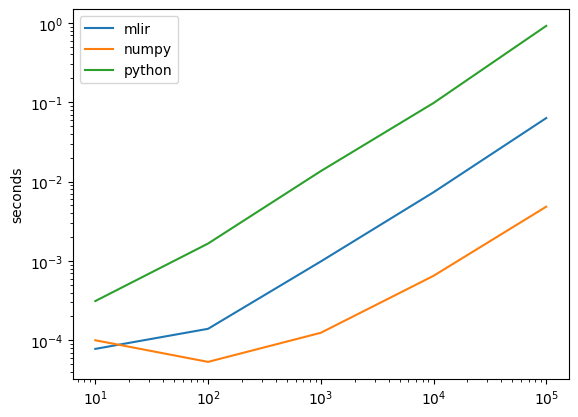

In [35]:
df.plot(logy=True, logx=True, ylabel="seconds")